<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [IMDB3] - Sentiment analysis with a LSTM network
<!-- DESC --> Still the same problem, but with a network combining embedding and LSTM
<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - The objective is to guess whether film reviews are **positive or negative** based on the analysis of the text. 
 - Use of a model combining embedding and LSTM

Original dataset can be find **[there](http://ai.stanford.edu/~amaas/data/sentiment/)**  
Note that [IMDb.com](https://imdb.com) offers several easy-to-use [datasets](https://www.imdb.com/interfaces/)  
For simplicity's sake, we'll use the dataset directly [embedded in Keras](https://www.tensorflow.org/api_docs/python/tf/keras/datasets)

## What we're going to do :

 - Retrieve data
 - Preparing the data
 - Build a Embedding/LSTM model
 - Train the model
 - Evaluate the result


## Step 1 - Init python stuff

In [1]:
import numpy as np

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.datasets.imdb as imdb

import matplotlib.pyplot as plt
import matplotlib

import os,sys,h5py,json
from importlib import reload

sys.path.append('..')
import fidle.pwk as pwk

datasets_dir = pwk.init('IMDB3')

<br>**FIDLE 2020 - Practical Work Module**

Version              : 2.0.14
Notebook id          : IMDB3
Run time             : Wednesday 10 February 2021, 10:47:42
TensorFlow version   : 2.4.0
Keras version        : 2.4.0
Datasets dir         : /gpfswork/rech/mlh/uja62cb/datasets
Run dir              : ./run
Update keras cache   : False
Save figs            : True
Path figs            : ./run/figs


## Step 2 - Retrieve data

IMDb dataset can bet get directly from Keras - see [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/datasets)  
Note : Due to their nature, textual data can be somewhat complex.

### 2.1 - Data structure :  
The dataset is composed of 2 parts: 

 - **reviews**, this will be our **x**
 - **opinions** (positive/negative), this will be our **y**

There are also a **dictionary**, because words are indexed in reviews

```
<dataset> = (<reviews>, <opinions>)

with :  <reviews>  = [ <review1>, <review2>, ... ]
        <opinions> = [ <rate1>,   <rate2>,   ... ]   where <ratei>   = integer

where : <reviewi> = [ <w1>, <w2>, ...]    <wi> are the index (int) of the word in the dictionary
        <ratei>   = int                   0 for negative opinion, 1 for positive


<dictionary> = [ <word1>:<w1>, <word2>:<w2>, ... ]

with :  <wordi>   = word
        <wi>      = int

```

### 2.2 - Get dataset
For simplicity, we will use a pre-formatted dataset - See [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb/load_data)  
However, Keras offers some usefull tools for formatting textual data - See [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text)  

**Load dataset :**

In [2]:
vocab_size = 10000

# ----- Retrieve x,y

# Uncomment this if you want to load dataset directly from keras (small size <20M)
#
(x_train, y_train), (x_test, y_test) = imdb.load_data( num_words  = vocab_size,
                                                       skip_top   = 0,
                                                       maxlen     = None,
                                                       seed       = 42,
                                                       start_char = 1,
                                                       oov_char   = 2,
                                                       index_from = 3, )

# To load a h5 version of the dataset :
#
# with  h5py.File(f'{datasets_dir}/IMDB/origine/dataset_imdb.h5','r') as f:
#        x_train = f['x_train'][:]
#        y_train = f['y_train'][:]
#        x_test  = f['x_test'][:]
#        y_test  = f['y_test'][:]

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


/gpfslocalsup/pub/anaconda-py3/2020.02/envs/tensorflow-gpu-2.4.0/lib/python3.7/site-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])


/gpfslocalsup/pub/anaconda-py3/2020.02/envs/tensorflow-gpu-2.4.0/lib/python3.7/site-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


**About this dataset :**

In [3]:
print("  Max(x_train,x_test)  : ", pwk.rmax([x_train,x_test]) )
print("  x_train : {}  y_train : {}".format(x_train.shape, y_train.shape))
print("  x_test  : {}  y_test  : {}".format(x_test.shape,  y_test.shape))

print('\nReview example (x_train[12]) :\n\n',x_train[12])

  Max(x_train,x_test)  :  9999
  x_train : (25000,)  y_train : (25000,)
  x_test  : (25000,)  y_test  : (25000,)

Review example (x_train[12]) :

 [1, 14, 22, 1367, 53, 206, 159, 4, 636, 898, 74, 26, 11, 436, 363, 108, 7, 14, 432, 14, 22, 9, 1055, 34, 8599, 2, 5, 381, 3705, 4509, 14, 768, 47, 839, 25, 111, 1517, 2579, 1991, 438, 2663, 587, 4, 280, 725, 6, 58, 11, 2714, 201, 4, 206, 16, 702, 5, 5176, 19, 480, 5920, 157, 13, 64, 219, 4, 2, 11, 107, 665, 1212, 39, 4, 206, 4, 65, 410, 16, 565, 5, 24, 43, 343, 17, 5602, 8, 169, 101, 85, 206, 108, 8, 3008, 14, 25, 215, 168, 18, 6, 2579, 1991, 438, 2, 11, 129, 1609, 36, 26, 66, 290, 3303, 46, 5, 633, 115, 4363]


### 2.3 - Have a look for humans (optional)
When we loaded the dataset, we asked for using \<start\> as 1, \<unknown word\> as 2  
So, we shifted the dataset by 3 with the parameter index_from=3

**Load dictionary :**

In [4]:
# ---- Retrieve dictionary {word:index}, and encode it in ascii
#
word_index = imdb.get_word_index()

# ---- Shift the dictionary from +3
#
word_index = {w:(i+3) for w,i in word_index.items()}

# ---- Add <pad>, <start> and unknown tags
#
word_index.update( {'<pad>':0, '<start>':1, '<unknown>':2} )

# ---- Create a reverse dictionary : {index:word}
#
index_word = {index:word for word,index in word_index.items()} 

# ---- Add a nice function to transpose :
#
def dataset2text(review):
    return ' '.join([index_word.get(i, '?') for i in review])

**Have a look :**

In [5]:
print('\nDictionary size     : ', len(word_index))
for k in range(440,455):print(f'{k:2d} : {index_word[k]}' )
pwk.subtitle('Review example :')
print(x_train[12])
pwk.subtitle('After translation :')
print(dataset2text(x_train[12]))


Dictionary size     :  88587
440 : hope
441 : entertaining
442 : she's
443 : mr
444 : overall
445 : evil
446 : called
447 : loved
448 : based
449 : oh
450 : several
451 : fans
452 : mother
453 : drama
454 : beginning


<br>**Review example :**

[1, 14, 22, 1367, 53, 206, 159, 4, 636, 898, 74, 26, 11, 436, 363, 108, 7, 14, 432, 14, 22, 9, 1055, 34, 8599, 2, 5, 381, 3705, 4509, 14, 768, 47, 839, 25, 111, 1517, 2579, 1991, 438, 2663, 587, 4, 280, 725, 6, 58, 11, 2714, 201, 4, 206, 16, 702, 5, 5176, 19, 480, 5920, 157, 13, 64, 219, 4, 2, 11, 107, 665, 1212, 39, 4, 206, 4, 65, 410, 16, 565, 5, 24, 43, 343, 17, 5602, 8, 169, 101, 85, 206, 108, 8, 3008, 14, 25, 215, 168, 18, 6, 2579, 1991, 438, 2, 11, 129, 1609, 36, 26, 66, 290, 3303, 46, 5, 633, 115, 4363]


<br>**After translation :**

<start> this film contains more action before the opening credits than are in entire hollywood films of this sort this film is produced by tsui <unknown> and stars jet li this team has brought you many worthy hong kong cinema productions including the once upon a time in china series the action was fast and furious with amazing wire work i only saw the <unknown> in two shots aside from the action the story itself was strong and not just used as filler to find any other action films to rival this you must look for a hong kong cinema <unknown> in your area they are really worth checking out and usually never disappoint


### 2.4 - Have a look for NN

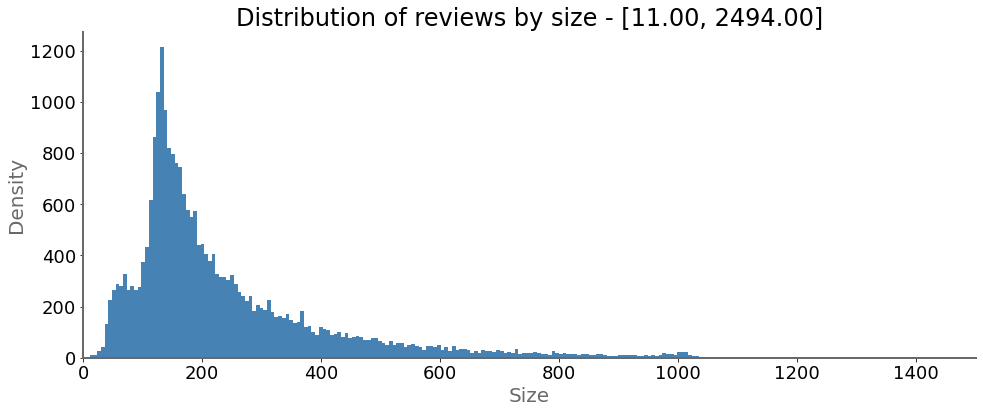

In [6]:
sizes=[len(i) for i in x_train]
plt.figure(figsize=(16,6))
plt.hist(sizes, bins=400)
plt.gca().set(title='Distribution of reviews by size - [{:5.2f}, {:5.2f}]'.format(min(sizes),max(sizes)), 
              xlabel='Size', ylabel='Density', xlim=[0,1500])
pwk.save_fig('01-stats-sizes')
plt.show()

## Step 3 - Preprocess the data (padding)
In order to be processed by an NN, all entries must have the **same length.**  
We chose a review length of **review_len**  
We will therefore complete them with a padding (of \<pad\>\)  

In [7]:
review_len = 256

x_train = keras.preprocessing.sequence.pad_sequences(x_train,
                                                     value   = 0,
                                                     padding = 'post',
                                                     maxlen  = review_len)

x_test  = keras.preprocessing.sequence.pad_sequences(x_test,
                                                     value   = 0 ,
                                                     padding = 'post',
                                                     maxlen  = review_len)

pwk.subtitle('After padding :')
print(x_train[12])
pwk.subtitle('In real words :')
print(dataset2text(x_train[12]))

<br>**After padding :**

[   1   14   22 1367   53  206  159    4  636  898   74   26   11  436
  363  108    7   14  432   14   22    9 1055   34 8599    2    5  381
 3705 4509   14  768   47  839   25  111 1517 2579 1991  438 2663  587
    4  280  725    6   58   11 2714  201    4  206   16  702    5 5176
   19  480 5920  157   13   64  219    4    2   11  107  665 1212   39
    4  206    4   65  410   16  565    5   24   43  343   17 5602    8
  169  101   85  206  108    8 3008   14   25  215  168   18    6 2579
 1991  438    2   11  129 1609   36   26   66  290 3303   46    5  633
  115 4363    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

<br>**In real words :**

<start> this film contains more action before the opening credits than are in entire hollywood films of this sort this film is produced by tsui <unknown> and stars jet li this team has brought you many worthy hong kong cinema productions including the once upon a time in china series the action was fast and furious with amazing wire work i only saw the <unknown> in two shots aside from the action the story itself was strong and not just used as filler to find any other action films to rival this you must look for a hong kong cinema <unknown> in your area they are really worth checking out and usually never disappoint <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pa

**Save dataset and dictionary (For future use but not mandatory)**

In [8]:
# ---- Write dataset in a h5 file, could be usefull
#
output_dir = './data'
pwk.mkdir(output_dir)

with h5py.File(f'{output_dir}/dataset_imdb.h5', 'w') as f:
    f.create_dataset("x_train",    data=x_train)
    f.create_dataset("y_train",    data=y_train)
    f.create_dataset("x_test",     data=x_test)
    f.create_dataset("y_test",     data=y_test)

with open(f'{output_dir}/word_index.json', 'w') as fp:
    json.dump(word_index, fp)

with open(f'{output_dir}/index_word.json', 'w') as fp:
    json.dump(index_word, fp)

print('Saved.')

Saved.


## Step 4 - Build the model
Few remarks :
 - We'll choose a dense vector size for the embedding output with **dense_vector_size**
 - **GlobalAveragePooling1D** do a pooling on the last dimension : (None, lx, ly) -> (None, ly)  
   In other words: we average the set of vectors/words of a sentence
 - L'embedding de Keras fonctionne de manière supervisée. Il s'agit d'une couche de *vocab_size* neurones vers *n_neurons* permettant de maintenir une table de vecteurs (les poids constituent les vecteurs). Cette couche ne calcule pas de sortie a la façon des couches normales, mais renvois la valeur des vecteurs. n mots => n vecteurs (ensuite empilés par le pooling)  
Voir : [Explication plus détaillée (en)](https://stats.stackexchange.com/questions/324992/how-the-embedding-layer-is-trained-in-keras-embedding-layer)  
ainsi que : [Sentiment detection with Keras](https://www.liip.ch/en/blog/sentiment-detection-with-keras-word-embeddings-and-lstm-deep-learning-networks)  

More documentation about this model functions :
 - [Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding)
 - [GlobalAveragePooling1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling1D)

In [9]:
def get_model(dense_vector_size=128):
    
    model = keras.Sequential()
    model.add(keras.layers.Embedding(input_dim    = vocab_size, 
                                     output_dim   = dense_vector_size, 
                                     input_length = review_len))
    model.add(keras.layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2))
    model.add(keras.layers.Dense(1,                 activation='sigmoid'))

    model.compile(optimizer = 'adam',
                  loss      = 'binary_crossentropy',
                  metrics   = ['accuracy'])
    return model

## Step 5 - Train the model
### 5.1 - Get it

In [10]:
model = get_model(32)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 256, 32)           320000    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               82432     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 402,561
Trainable params: 402,561
Non-trainable params: 0
_________________________________________________________________


### 5.2 - Add callback

In [11]:
os.makedirs('./run/models',   mode=0o750, exist_ok=True)
save_dir = "./run/models/best_model.h5"
savemodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, save_best_only=True)

### 5.1 - Train it
GPU : batch_size=512 :  6' 30s  
CPU : batch_size=512 : 12' 57s

In [12]:
%%time

n_epochs   = 10
batch_size = 512

history = model.fit(x_train,
                    y_train,
                    epochs          = n_epochs,
                    batch_size      = batch_size,
                    validation_data = (x_test, y_test),
                    verbose         = 1,
                    callbacks       = [savemodel_callback])


Epoch 1/10


 1/49 [..............................] - ETA: 4:18 - loss: 0.6935 - accuracy: 0.4883

 2/49 [>.............................] - ETA: 29s - loss: 0.6938 - accuracy: 0.4761 

 3/49 [>.............................] - ETA: 28s - loss: 0.6938 - accuracy: 0.4747

 4/49 [=>............................] - ETA: 27s - loss: 0.6938 - accuracy: 0.4770

 5/49 [==>...........................] - ETA: 27s - loss: 0.6938 - accuracy: 0.4784

 6/49 [==>...........................] - ETA: 26s - loss: 0.6938 - accuracy: 0.4791

 7/49 [===>..........................] - ETA: 25s - loss: 0.6937 - accuracy: 0.4794

 8/49 [===>..........................] - ETA: 25s - loss: 0.6937 - accuracy: 0.4803

 9/49 [====>.........................] - ETA: 24s - loss: 0.6937 - accuracy: 0.4813

10/49 [=====>........................] - ETA: 23s - loss: 0.6937 - accuracy: 0.4825

11/49 [=====>........................] - ETA: 23s - loss: 0.6937 - accuracy: 0.4836

12/49 [======>.......................] - ETA: 22s - loss: 0.6936 - accuracy: 0.4848

13/49 [======>.......................] - ETA: 22s - loss: 0.6936 - accuracy: 0.4859

14/49 [=======>......................] - ETA: 21s - loss: 0.6936 - accuracy: 0.4869

15/49 [========>.....................] - ETA: 20s - loss: 0.6936 - accuracy: 0.4879

16/49 [========>.....................] - ETA: 20s - loss: 0.6936 - accuracy: 0.4888

17/49 [=========>....................] - ETA: 19s - loss: 0.6935 - accuracy: 0.4896

18/49 [==========>...................] - ETA: 19s - loss: 0.6935 - accuracy: 0.4902

19/49 [==========>...................] - ETA: 18s - loss: 0.6935 - accuracy: 0.4907

20/49 [===========>..................] - ETA: 17s - loss: 0.6935 - accuracy: 0.4912

21/49 [===========>..................] - ETA: 17s - loss: 0.6935 - accuracy: 0.4917

22/49 [============>.................] - ETA: 16s - loss: 0.6935 - accuracy: 0.4921

23/49 [=============>................] - ETA: 16s - loss: 0.6935 - accuracy: 0.4926

24/49 [=============>................] - ETA: 15s - loss: 0.6935 - accuracy: 0.4930

25/49 [==============>...............] - ETA: 14s - loss: 0.6935 - accuracy: 0.4935

26/49 [==============>...............] - ETA: 14s - loss: 0.6934 - accuracy: 0.4940

27/49 [===============>..............] - ETA: 13s - loss: 0.6934 - accuracy: 0.4945

28/49 [================>.............] - ETA: 13s - loss: 0.6934 - accuracy: 0.4950

29/49 [================>.............] - ETA: 12s - loss: 0.6934 - accuracy: 0.4955

30/49 [=================>............] - ETA: 11s - loss: 0.6934 - accuracy: 0.4960

31/49 [=================>............] - ETA: 11s - loss: 0.6934 - accuracy: 0.4965

32/49 [==================>...........] - ETA: 10s - loss: 0.6934 - accuracy: 0.4970

33/49 [===================>..........] - ETA: 9s - loss: 0.6934 - accuracy: 0.4975 

34/49 [===================>..........] - ETA: 9s - loss: 0.6933 - accuracy: 0.4980

35/49 [====================>.........] - ETA: 8s - loss: 0.6933 - accuracy: 0.4985

36/49 [=====================>........] - ETA: 8s - loss: 0.6933 - accuracy: 0.4990

37/49 [=====================>........] - ETA: 7s - loss: 0.6933 - accuracy: 0.4994

38/49 [======================>.......] - ETA: 6s - loss: 0.6933 - accuracy: 0.4997

39/49 [======================>.......] - ETA: 6s - loss: 0.6933 - accuracy: 0.5001

40/49 [=======================>......] - ETA: 5s - loss: 0.6933 - accuracy: 0.5004

41/49 [========================>.....] - ETA: 4s - loss: 0.6932 - accuracy: 0.5007

42/49 [========================>.....] - ETA: 4s - loss: 0.6932 - accuracy: 0.5011

43/49 [=========================>....] - ETA: 3s - loss: 0.6932 - accuracy: 0.5014

44/49 [=========================>....] - ETA: 3s - loss: 0.6932 - accuracy: 0.5016

45/49 [==========================>...] - ETA: 2s - loss: 0.6932 - accuracy: 0.5019

46/49 [===========================>..] - ETA: 1s - loss: 0.6931 - accuracy: 0.5023

47/49 [===========================>..] - ETA: 1s - loss: 0.6931 - accuracy: 0.5026

48/49 [============================>.] - ETA: 0s - loss: 0.6930 - accuracy: 0.5030

49/49 [==============================] - ETA: 0s - loss: 0.6930 - accuracy: 0.5033

49/49 [==============================] - 39s 709ms/step - loss: 0.6929 - accuracy: 0.5036 - val_loss: 0.6869 - val_accuracy: 0.5288


Epoch 2/10


 1/49 [..............................] - ETA: 31s - loss: 0.6897 - accuracy: 0.5254

 2/49 [>.............................] - ETA: 29s - loss: 0.6889 - accuracy: 0.5254

 3/49 [>.............................] - ETA: 28s - loss: 0.6884 - accuracy: 0.5247

 4/49 [=>............................] - ETA: 27s - loss: 0.6881 - accuracy: 0.5250

 5/49 [==>...........................] - ETA: 27s - loss: 0.6880 - accuracy: 0.5247

 6/49 [==>...........................] - ETA: 26s - loss: 0.6881 - accuracy: 0.5239

 7/49 [===>..........................] - ETA: 25s - loss: 0.6881 - accuracy: 0.5233

 8/49 [===>..........................] - ETA: 25s - loss: 0.6881 - accuracy: 0.5233

 9/49 [====>.........................] - ETA: 24s - loss: 0.6880 - accuracy: 0.5237

10/49 [=====>........................] - ETA: 23s - loss: 0.6879 - accuracy: 0.5239

11/49 [=====>........................] - ETA: 23s - loss: 0.6878 - accuracy: 0.5244

12/49 [======>.......................] - ETA: 22s - loss: 0.6878 - accuracy: 0.5249

13/49 [======>.......................] - ETA: 22s - loss: 0.6877 - accuracy: 0.5254

14/49 [=======>......................] - ETA: 21s - loss: 0.6876 - accuracy: 0.5258

15/49 [========>.....................] - ETA: 20s - loss: 0.6876 - accuracy: 0.5262

16/49 [========>.....................] - ETA: 20s - loss: 0.6875 - accuracy: 0.5265

17/49 [=========>....................] - ETA: 19s - loss: 0.6875 - accuracy: 0.5268

18/49 [==========>...................] - ETA: 19s - loss: 0.6874 - accuracy: 0.5271

19/49 [==========>...................] - ETA: 18s - loss: 0.6874 - accuracy: 0.5274

20/49 [===========>..................] - ETA: 17s - loss: 0.6873 - accuracy: 0.5278

21/49 [===========>..................] - ETA: 17s - loss: 0.6873 - accuracy: 0.5282

22/49 [============>.................] - ETA: 16s - loss: 0.6872 - accuracy: 0.5286

23/49 [=============>................] - ETA: 16s - loss: 0.6872 - accuracy: 0.5289

24/49 [=============>................] - ETA: 15s - loss: 0.6871 - accuracy: 0.5293

25/49 [==============>...............] - ETA: 14s - loss: 0.6871 - accuracy: 0.5296

26/49 [==============>...............] - ETA: 14s - loss: 0.6870 - accuracy: 0.5300

27/49 [===============>..............] - ETA: 13s - loss: 0.6870 - accuracy: 0.5303

28/49 [================>.............] - ETA: 12s - loss: 0.6869 - accuracy: 0.5306

29/49 [================>.............] - ETA: 12s - loss: 0.6869 - accuracy: 0.5309

30/49 [=================>............] - ETA: 11s - loss: 0.6868 - accuracy: 0.5311

31/49 [=================>............] - ETA: 11s - loss: 0.6867 - accuracy: 0.5314

32/49 [==================>...........] - ETA: 10s - loss: 0.6867 - accuracy: 0.5316

33/49 [===================>..........] - ETA: 9s - loss: 0.6866 - accuracy: 0.5318 

34/49 [===================>..........] - ETA: 9s - loss: 0.6865 - accuracy: 0.5320

35/49 [====================>.........] - ETA: 8s - loss: 0.6864 - accuracy: 0.5322

36/49 [=====================>........] - ETA: 7s - loss: 0.6864 - accuracy: 0.5324

37/49 [=====================>........] - ETA: 7s - loss: 0.6863 - accuracy: 0.5327

38/49 [======================>.......] - ETA: 6s - loss: 0.6862 - accuracy: 0.5331

39/49 [======================>.......] - ETA: 6s - loss: 0.6861 - accuracy: 0.5334

40/49 [=======================>......] - ETA: 5s - loss: 0.6861 - accuracy: 0.5337

41/49 [========================>.....] - ETA: 4s - loss: 0.6860 - accuracy: 0.5339

42/49 [========================>.....] - ETA: 4s - loss: 0.6860 - accuracy: 0.5342

43/49 [=========================>....] - ETA: 3s - loss: 0.6859 - accuracy: 0.5345

44/49 [=========================>....] - ETA: 3s - loss: 0.6858 - accuracy: 0.5348

45/49 [==========================>...] - ETA: 2s - loss: 0.6858 - accuracy: 0.5350

46/49 [===========================>..] - ETA: 1s - loss: 0.6857 - accuracy: 0.5353

47/49 [===========================>..] - ETA: 1s - loss: 0.6857 - accuracy: 0.5355

48/49 [============================>.] - ETA: 0s - loss: 0.6856 - accuracy: 0.5357

49/49 [==============================] - ETA: 0s - loss: 0.6856 - accuracy: 0.5359

49/49 [==============================] - 33s 680ms/step - loss: 0.6855 - accuracy: 0.5361 - val_loss: 0.6823 - val_accuracy: 0.5360


Epoch 3/10


 1/49 [..............................] - ETA: 31s - loss: 0.6761 - accuracy: 0.5527

 2/49 [>.............................] - ETA: 28s - loss: 0.6766 - accuracy: 0.5547

 3/49 [>.............................] - ETA: 27s - loss: 0.6760 - accuracy: 0.5603

 4/49 [=>............................] - ETA: 27s - loss: 0.6759 - accuracy: 0.5608

 5/49 [==>...........................] - ETA: 26s - loss: 0.6758 - accuracy: 0.5619

 6/49 [==>...........................] - ETA: 26s - loss: 0.6759 - accuracy: 0.5617

 7/49 [===>..........................] - ETA: 25s - loss: 0.6758 - accuracy: 0.5617

 8/49 [===>..........................] - ETA: 25s - loss: 0.6757 - accuracy: 0.5620

 9/49 [====>.........................] - ETA: 24s - loss: 0.6757 - accuracy: 0.5619

10/49 [=====>........................] - ETA: 23s - loss: 0.6756 - accuracy: 0.5622

11/49 [=====>........................] - ETA: 23s - loss: 0.6756 - accuracy: 0.5620

12/49 [======>.......................] - ETA: 22s - loss: 0.6755 - accuracy: 0.5622

13/49 [======>.......................] - ETA: 22s - loss: 0.6754 - accuracy: 0.5624

14/49 [=======>......................] - ETA: 21s - loss: 0.6754 - accuracy: 0.5625

15/49 [========>.....................] - ETA: 20s - loss: 0.6753 - accuracy: 0.5626

16/49 [========>.....................] - ETA: 20s - loss: 0.6752 - accuracy: 0.5628

17/49 [=========>....................] - ETA: 19s - loss: 0.6751 - accuracy: 0.5628

18/49 [==========>...................] - ETA: 19s - loss: 0.6750 - accuracy: 0.5630

19/49 [==========>...................] - ETA: 18s - loss: 0.6750 - accuracy: 0.5632

20/49 [===========>..................] - ETA: 17s - loss: 0.6749 - accuracy: 0.5633

21/49 [===========>..................] - ETA: 17s - loss: 0.6748 - accuracy: 0.5634

22/49 [============>.................] - ETA: 16s - loss: 0.6747 - accuracy: 0.5635

23/49 [=============>................] - ETA: 15s - loss: 0.6746 - accuracy: 0.5637

24/49 [=============>................] - ETA: 15s - loss: 0.6746 - accuracy: 0.5638

25/49 [==============>...............] - ETA: 14s - loss: 0.6745 - accuracy: 0.5639

26/49 [==============>...............] - ETA: 14s - loss: 0.6744 - accuracy: 0.5640

27/49 [===============>..............] - ETA: 13s - loss: 0.6743 - accuracy: 0.5641

28/49 [================>.............] - ETA: 12s - loss: 0.6743 - accuracy: 0.5642

29/49 [================>.............] - ETA: 12s - loss: 0.6742 - accuracy: 0.5643

30/49 [=================>............] - ETA: 11s - loss: 0.6741 - accuracy: 0.5645

31/49 [=================>............] - ETA: 11s - loss: 0.6740 - accuracy: 0.5645

32/49 [==================>...........] - ETA: 10s - loss: 0.6739 - accuracy: 0.5646

33/49 [===================>..........] - ETA: 9s - loss: 0.6738 - accuracy: 0.5647 

34/49 [===================>..........] - ETA: 9s - loss: 0.6737 - accuracy: 0.5648

35/49 [====================>.........] - ETA: 8s - loss: 0.6736 - accuracy: 0.5649

36/49 [=====================>........] - ETA: 7s - loss: 0.6735 - accuracy: 0.5650

37/49 [=====================>........] - ETA: 7s - loss: 0.6734 - accuracy: 0.5651

38/49 [======================>.......] - ETA: 6s - loss: 0.6733 - accuracy: 0.5653

39/49 [======================>.......] - ETA: 6s - loss: 0.6731 - accuracy: 0.5654

40/49 [=======================>......] - ETA: 5s - loss: 0.6730 - accuracy: 0.5655

41/49 [========================>.....] - ETA: 4s - loss: 0.6729 - accuracy: 0.5656

42/49 [========================>.....] - ETA: 4s - loss: 0.6728 - accuracy: 0.5657

43/49 [=========================>....] - ETA: 3s - loss: 0.6726 - accuracy: 0.5658

44/49 [=========================>....] - ETA: 3s - loss: 0.6725 - accuracy: 0.5659

45/49 [==========================>...] - ETA: 2s - loss: 0.6723 - accuracy: 0.5661

46/49 [===========================>..] - ETA: 1s - loss: 0.6722 - accuracy: 0.5662

47/49 [===========================>..] - ETA: 1s - loss: 0.6720 - accuracy: 0.5664

48/49 [============================>.] - ETA: 0s - loss: 0.6718 - accuracy: 0.5666

49/49 [==============================] - ETA: 0s - loss: 0.6716 - accuracy: 0.5668

49/49 [==============================] - 33s 677ms/step - loss: 0.6715 - accuracy: 0.5671 - val_loss: 0.5416 - val_accuracy: 0.7500


Epoch 4/10


 1/49 [..............................] - ETA: 29s - loss: 0.5361 - accuracy: 0.7480

 2/49 [>.............................] - ETA: 30s - loss: 0.5282 - accuracy: 0.7505

 3/49 [>.............................] - ETA: 29s - loss: 0.5276 - accuracy: 0.7486

 4/49 [=>............................] - ETA: 28s - loss: 0.5256 - accuracy: 0.7482

 5/49 [==>...........................] - ETA: 27s - loss: 0.5268 - accuracy: 0.7445

 6/49 [==>...........................] - ETA: 26s - loss: 0.5253 - accuracy: 0.7439

 7/49 [===>..........................] - ETA: 25s - loss: 0.5237 - accuracy: 0.7443

 8/49 [===>..........................] - ETA: 25s - loss: 0.5214 - accuracy: 0.7456

 9/49 [====>.........................] - ETA: 24s - loss: 0.5189 - accuracy: 0.7475

10/49 [=====>........................] - ETA: 23s - loss: 0.5164 - accuracy: 0.7495

11/49 [=====>........................] - ETA: 23s - loss: 0.5142 - accuracy: 0.7516

12/49 [======>.......................] - ETA: 22s - loss: 0.5123 - accuracy: 0.7535

13/49 [======>.......................] - ETA: 22s - loss: 0.5105 - accuracy: 0.7553

14/49 [=======>......................] - ETA: 21s - loss: 0.5086 - accuracy: 0.7572

15/49 [========>.....................] - ETA: 20s - loss: 0.5066 - accuracy: 0.7590

16/49 [========>.....................] - ETA: 20s - loss: 0.5047 - accuracy: 0.7608

17/49 [=========>....................] - ETA: 19s - loss: 0.5028 - accuracy: 0.7625

18/49 [==========>...................] - ETA: 18s - loss: 0.5012 - accuracy: 0.7641

19/49 [==========>...................] - ETA: 18s - loss: 0.4998 - accuracy: 0.7654

20/49 [===========>..................] - ETA: 17s - loss: 0.4986 - accuracy: 0.7666

21/49 [===========>..................] - ETA: 17s - loss: 0.4976 - accuracy: 0.7676

22/49 [============>.................] - ETA: 16s - loss: 0.4965 - accuracy: 0.7687

23/49 [=============>................] - ETA: 15s - loss: 0.4952 - accuracy: 0.7698

24/49 [=============>................] - ETA: 15s - loss: 0.4940 - accuracy: 0.7710

25/49 [==============>...............] - ETA: 14s - loss: 0.4930 - accuracy: 0.7720

26/49 [==============>...............] - ETA: 14s - loss: 0.4920 - accuracy: 0.7730

27/49 [===============>..............] - ETA: 13s - loss: 0.4910 - accuracy: 0.7740

28/49 [================>.............] - ETA: 12s - loss: 0.4900 - accuracy: 0.7750

29/49 [================>.............] - ETA: 12s - loss: 0.4891 - accuracy: 0.7759

30/49 [=================>............] - ETA: 11s - loss: 0.4881 - accuracy: 0.7768

31/49 [=================>............] - ETA: 11s - loss: 0.4871 - accuracy: 0.7777

32/49 [==================>...........] - ETA: 10s - loss: 0.4861 - accuracy: 0.7786

33/49 [===================>..........] - ETA: 9s - loss: 0.4851 - accuracy: 0.7795 

34/49 [===================>..........] - ETA: 9s - loss: 0.4841 - accuracy: 0.7804

35/49 [====================>.........] - ETA: 8s - loss: 0.4830 - accuracy: 0.7813

36/49 [=====================>........] - ETA: 7s - loss: 0.4821 - accuracy: 0.7821

37/49 [=====================>........] - ETA: 7s - loss: 0.4811 - accuracy: 0.7830

38/49 [======================>.......] - ETA: 6s - loss: 0.4802 - accuracy: 0.7837

39/49 [======================>.......] - ETA: 6s - loss: 0.4793 - accuracy: 0.7845

40/49 [=======================>......] - ETA: 5s - loss: 0.4784 - accuracy: 0.7852

41/49 [========================>.....] - ETA: 4s - loss: 0.4776 - accuracy: 0.7859

42/49 [========================>.....] - ETA: 4s - loss: 0.4768 - accuracy: 0.7866

43/49 [=========================>....] - ETA: 3s - loss: 0.4761 - accuracy: 0.7872

44/49 [=========================>....] - ETA: 3s - loss: 0.4753 - accuracy: 0.7879

45/49 [==========================>...] - ETA: 2s - loss: 0.4746 - accuracy: 0.7885

46/49 [===========================>..] - ETA: 1s - loss: 0.4739 - accuracy: 0.7891

47/49 [===========================>..] - ETA: 1s - loss: 0.4732 - accuracy: 0.7897

48/49 [============================>.] - ETA: 0s - loss: 0.4725 - accuracy: 0.7903

49/49 [==============================] - ETA: 0s - loss: 0.4718 - accuracy: 0.7909

49/49 [==============================] - 33s 680ms/step - loss: 0.4711 - accuracy: 0.7915 - val_loss: 0.4160 - val_accuracy: 0.8304


Epoch 5/10


 1/49 [..............................] - ETA: 29s - loss: 0.3674 - accuracy: 0.8633

 2/49 [>.............................] - ETA: 28s - loss: 0.3710 - accuracy: 0.8618

 3/49 [>.............................] - ETA: 28s - loss: 0.3806 - accuracy: 0.8567

 4/49 [=>............................] - ETA: 27s - loss: 0.3868 - accuracy: 0.8536

 5/49 [==>...........................] - ETA: 26s - loss: 0.3904 - accuracy: 0.8513

 6/49 [==>...........................] - ETA: 26s - loss: 0.3931 - accuracy: 0.8493

 7/49 [===>..........................] - ETA: 25s - loss: 0.3941 - accuracy: 0.8484

 8/49 [===>..........................] - ETA: 25s - loss: 0.3940 - accuracy: 0.8484

 9/49 [====>.........................] - ETA: 24s - loss: 0.3932 - accuracy: 0.8487

10/49 [=====>........................] - ETA: 23s - loss: 0.3920 - accuracy: 0.8492

11/49 [=====>........................] - ETA: 23s - loss: 0.3915 - accuracy: 0.8495

12/49 [======>.......................] - ETA: 22s - loss: 0.3910 - accuracy: 0.8498

13/49 [======>.......................] - ETA: 22s - loss: 0.3904 - accuracy: 0.8501

14/49 [=======>......................] - ETA: 21s - loss: 0.3899 - accuracy: 0.8505

15/49 [========>.....................] - ETA: 20s - loss: 0.3895 - accuracy: 0.8507

16/49 [========>.....................] - ETA: 20s - loss: 0.3892 - accuracy: 0.8510

17/49 [=========>....................] - ETA: 19s - loss: 0.3887 - accuracy: 0.8513

18/49 [==========>...................] - ETA: 19s - loss: 0.3881 - accuracy: 0.8517

19/49 [==========>...................] - ETA: 18s - loss: 0.3875 - accuracy: 0.8521

20/49 [===========>..................] - ETA: 17s - loss: 0.3869 - accuracy: 0.8526

21/49 [===========>..................] - ETA: 17s - loss: 0.3865 - accuracy: 0.8530

22/49 [============>.................] - ETA: 16s - loss: 0.3861 - accuracy: 0.8533

23/49 [=============>................] - ETA: 16s - loss: 0.3857 - accuracy: 0.8537

24/49 [=============>................] - ETA: 15s - loss: 0.3853 - accuracy: 0.8540

25/49 [==============>...............] - ETA: 14s - loss: 0.3850 - accuracy: 0.8543

26/49 [==============>...............] - ETA: 14s - loss: 0.3847 - accuracy: 0.8545

27/49 [===============>..............] - ETA: 13s - loss: 0.3843 - accuracy: 0.8548

28/49 [================>.............] - ETA: 12s - loss: 0.3842 - accuracy: 0.8550

29/49 [================>.............] - ETA: 12s - loss: 0.3841 - accuracy: 0.8552

30/49 [=================>............] - ETA: 11s - loss: 0.3840 - accuracy: 0.8553

31/49 [=================>............] - ETA: 11s - loss: 0.3844 - accuracy: 0.8552

32/49 [==================>...........] - ETA: 10s - loss: 0.3850 - accuracy: 0.8549

33/49 [===================>..........] - ETA: 9s - loss: 0.3859 - accuracy: 0.8543 

34/49 [===================>..........] - ETA: 9s - loss: 0.3870 - accuracy: 0.8536

35/49 [====================>.........] - ETA: 8s - loss: 0.3882 - accuracy: 0.8527

36/49 [=====================>........] - ETA: 7s - loss: 0.3894 - accuracy: 0.8517

37/49 [=====================>........] - ETA: 7s - loss: 0.3908 - accuracy: 0.8506

38/49 [======================>.......] - ETA: 6s - loss: 0.3922 - accuracy: 0.8494

39/49 [======================>.......] - ETA: 6s - loss: 0.3937 - accuracy: 0.8481

40/49 [=======================>......] - ETA: 5s - loss: 0.3952 - accuracy: 0.8467

41/49 [========================>.....] - ETA: 4s - loss: 0.3967 - accuracy: 0.8453

42/49 [========================>.....] - ETA: 4s - loss: 0.3983 - accuracy: 0.8438

43/49 [=========================>....] - ETA: 3s - loss: 0.4000 - accuracy: 0.8423

44/49 [=========================>....] - ETA: 3s - loss: 0.4016 - accuracy: 0.8407

45/49 [==========================>...] - ETA: 2s - loss: 0.4033 - accuracy: 0.8391

46/49 [===========================>..] - ETA: 1s - loss: 0.4049 - accuracy: 0.8375

47/49 [===========================>..] - ETA: 1s - loss: 0.4066 - accuracy: 0.8358

48/49 [============================>.] - ETA: 0s - loss: 0.4083 - accuracy: 0.8341

49/49 [==============================] - ETA: 0s - loss: 0.4100 - accuracy: 0.8325

49/49 [==============================] - 33s 682ms/step - loss: 0.4116 - accuracy: 0.8309 - val_loss: 0.6712 - val_accuracy: 0.5570


Epoch 6/10


 1/49 [..............................] - ETA: 26s - loss: 0.6444 - accuracy: 0.6113

 2/49 [>.............................] - ETA: 29s - loss: 0.6513 - accuracy: 0.5962

 3/49 [>.............................] - ETA: 28s - loss: 0.6526 - accuracy: 0.5904

 4/49 [=>............................] - ETA: 27s - loss: 0.6526 - accuracy: 0.5882

 5/49 [==>...........................] - ETA: 26s - loss: 0.6526 - accuracy: 0.5855

 6/49 [==>...........................] - ETA: 26s - loss: 0.6525 - accuracy: 0.5838

 7/49 [===>..........................] - ETA: 25s - loss: 0.6522 - accuracy: 0.5828

 8/49 [===>..........................] - ETA: 25s - loss: 0.6520 - accuracy: 0.5819

 9/49 [====>.........................] - ETA: 24s - loss: 0.6520 - accuracy: 0.5813

10/49 [=====>........................] - ETA: 23s - loss: 0.6519 - accuracy: 0.5807

11/49 [=====>........................] - ETA: 23s - loss: 0.6519 - accuracy: 0.5799

12/49 [======>.......................] - ETA: 22s - loss: 0.6519 - accuracy: 0.5792

13/49 [======>.......................] - ETA: 22s - loss: 0.6520 - accuracy: 0.5785

14/49 [=======>......................] - ETA: 21s - loss: 0.6520 - accuracy: 0.5778

15/49 [========>.....................] - ETA: 20s - loss: 0.6520 - accuracy: 0.5773

16/49 [========>.....................] - ETA: 20s - loss: 0.6520 - accuracy: 0.5771

17/49 [=========>....................] - ETA: 19s - loss: 0.6519 - accuracy: 0.5768

18/49 [==========>...................] - ETA: 18s - loss: 0.6519 - accuracy: 0.5765

19/49 [==========>...................] - ETA: 18s - loss: 0.6518 - accuracy: 0.5763

20/49 [===========>..................] - ETA: 17s - loss: 0.6517 - accuracy: 0.5763

21/49 [===========>..................] - ETA: 17s - loss: 0.6516 - accuracy: 0.5763

22/49 [============>.................] - ETA: 16s - loss: 0.6515 - accuracy: 0.5763

23/49 [=============>................] - ETA: 15s - loss: 0.6513 - accuracy: 0.5763

24/49 [=============>................] - ETA: 15s - loss: 0.6512 - accuracy: 0.5764

25/49 [==============>...............] - ETA: 14s - loss: 0.6511 - accuracy: 0.5764

26/49 [==============>...............] - ETA: 14s - loss: 0.6509 - accuracy: 0.5765

27/49 [===============>..............] - ETA: 13s - loss: 0.6508 - accuracy: 0.5765

28/49 [================>.............] - ETA: 12s - loss: 0.6507 - accuracy: 0.5765

29/49 [================>.............] - ETA: 12s - loss: 0.6506 - accuracy: 0.5765

30/49 [=================>............] - ETA: 11s - loss: 0.6505 - accuracy: 0.5765

31/49 [=================>............] - ETA: 11s - loss: 0.6504 - accuracy: 0.5765

32/49 [==================>...........] - ETA: 10s - loss: 0.6503 - accuracy: 0.5765

33/49 [===================>..........] - ETA: 9s - loss: 0.6502 - accuracy: 0.5765 

34/49 [===================>..........] - ETA: 9s - loss: 0.6501 - accuracy: 0.5765

35/49 [====================>.........] - ETA: 8s - loss: 0.6500 - accuracy: 0.5766

36/49 [=====================>........] - ETA: 7s - loss: 0.6499 - accuracy: 0.5767

37/49 [=====================>........] - ETA: 7s - loss: 0.6498 - accuracy: 0.5767

38/49 [======================>.......] - ETA: 6s - loss: 0.6497 - accuracy: 0.5768

39/49 [======================>.......] - ETA: 6s - loss: 0.6496 - accuracy: 0.5768

40/49 [=======================>......] - ETA: 5s - loss: 0.6495 - accuracy: 0.5769

41/49 [========================>.....] - ETA: 4s - loss: 0.6494 - accuracy: 0.5769

42/49 [========================>.....] - ETA: 4s - loss: 0.6493 - accuracy: 0.5769

43/49 [=========================>....] - ETA: 3s - loss: 0.6492 - accuracy: 0.5770

44/49 [=========================>....] - ETA: 3s - loss: 0.6491 - accuracy: 0.5770

45/49 [==========================>...] - ETA: 2s - loss: 0.6490 - accuracy: 0.5770

46/49 [===========================>..] - ETA: 1s - loss: 0.6490 - accuracy: 0.5770

47/49 [===========================>..] - ETA: 1s - loss: 0.6489 - accuracy: 0.5770

48/49 [============================>.] - ETA: 0s - loss: 0.6488 - accuracy: 0.5771

49/49 [==============================] - ETA: 0s - loss: 0.6487 - accuracy: 0.5771

49/49 [==============================] - 33s 679ms/step - loss: 0.6486 - accuracy: 0.5771 - val_loss: 0.6573 - val_accuracy: 0.6009


Epoch 7/10


 1/49 [..............................] - ETA: 29s - loss: 0.6307 - accuracy: 0.5859

 2/49 [>.............................] - ETA: 28s - loss: 0.6368 - accuracy: 0.5845

 3/49 [>.............................] - ETA: 27s - loss: 0.6393 - accuracy: 0.5826

 4/49 [=>............................] - ETA: 27s - loss: 0.6399 - accuracy: 0.5830

 5/49 [==>...........................] - ETA: 26s - loss: 0.6396 - accuracy: 0.5850

 6/49 [==>...........................] - ETA: 26s - loss: 0.6391 - accuracy: 0.5860

 7/49 [===>..........................] - ETA: 25s - loss: 0.6384 - accuracy: 0.5873

 8/49 [===>..........................] - ETA: 24s - loss: 0.6381 - accuracy: 0.5883

 9/49 [====>.........................] - ETA: 24s - loss: 0.6376 - accuracy: 0.5896

10/49 [=====>........................] - ETA: 23s - loss: 0.6371 - accuracy: 0.5908

11/49 [=====>........................] - ETA: 23s - loss: 0.6368 - accuracy: 0.5919

12/49 [======>.......................] - ETA: 22s - loss: 0.6366 - accuracy: 0.5926

13/49 [======>.......................] - ETA: 21s - loss: 0.6363 - accuracy: 0.5934

14/49 [=======>......................] - ETA: 21s - loss: 0.6361 - accuracy: 0.5941

15/49 [========>.....................] - ETA: 20s - loss: 0.6358 - accuracy: 0.5948

16/49 [========>.....................] - ETA: 20s - loss: 0.6354 - accuracy: 0.5954

17/49 [=========>....................] - ETA: 19s - loss: 0.6351 - accuracy: 0.5962

18/49 [==========>...................] - ETA: 18s - loss: 0.6347 - accuracy: 0.5968

19/49 [==========>...................] - ETA: 18s - loss: 0.6343 - accuracy: 0.5974

20/49 [===========>..................] - ETA: 17s - loss: 0.6340 - accuracy: 0.5980

21/49 [===========>..................] - ETA: 17s - loss: 0.6337 - accuracy: 0.5986

22/49 [============>.................] - ETA: 16s - loss: 0.6334 - accuracy: 0.5992

23/49 [=============>................] - ETA: 15s - loss: 0.6330 - accuracy: 0.5998

24/49 [=============>................] - ETA: 15s - loss: 0.6327 - accuracy: 0.6004

25/49 [==============>...............] - ETA: 14s - loss: 0.6325 - accuracy: 0.6009

26/49 [==============>...............] - ETA: 13s - loss: 0.6322 - accuracy: 0.6014

27/49 [===============>..............] - ETA: 13s - loss: 0.6319 - accuracy: 0.6019

28/49 [================>.............] - ETA: 12s - loss: 0.6316 - accuracy: 0.6025

29/49 [================>.............] - ETA: 12s - loss: 0.6314 - accuracy: 0.6031

30/49 [=================>............] - ETA: 11s - loss: 0.6311 - accuracy: 0.6038

31/49 [=================>............] - ETA: 10s - loss: 0.6307 - accuracy: 0.6046

32/49 [==================>...........] - ETA: 10s - loss: 0.6303 - accuracy: 0.6056

33/49 [===================>..........] - ETA: 9s - loss: 0.6299 - accuracy: 0.6066 

34/49 [===================>..........] - ETA: 9s - loss: 0.6293 - accuracy: 0.6078

35/49 [====================>.........] - ETA: 8s - loss: 0.6286 - accuracy: 0.6090

36/49 [=====================>........] - ETA: 7s - loss: 0.6278 - accuracy: 0.6104

37/49 [=====================>........] - ETA: 7s - loss: 0.6268 - accuracy: 0.6118

38/49 [======================>.......] - ETA: 6s - loss: 0.6257 - accuracy: 0.6133

39/49 [======================>.......] - ETA: 6s - loss: 0.6246 - accuracy: 0.6148

40/49 [=======================>......] - ETA: 5s - loss: 0.6234 - accuracy: 0.6164

41/49 [========================>.....] - ETA: 4s - loss: 0.6221 - accuracy: 0.6180

42/49 [========================>.....] - ETA: 4s - loss: 0.6208 - accuracy: 0.6196

43/49 [=========================>....] - ETA: 3s - loss: 0.6193 - accuracy: 0.6213

44/49 [=========================>....] - ETA: 3s - loss: 0.6179 - accuracy: 0.6230

45/49 [==========================>...] - ETA: 2s - loss: 0.6164 - accuracy: 0.6248

46/49 [===========================>..] - ETA: 1s - loss: 0.6148 - accuracy: 0.6265

47/49 [===========================>..] - ETA: 1s - loss: 0.6133 - accuracy: 0.6282

48/49 [============================>.] - ETA: 0s - loss: 0.6117 - accuracy: 0.6300

49/49 [==============================] - ETA: 0s - loss: 0.6101 - accuracy: 0.6317

49/49 [==============================] - 33s 679ms/step - loss: 0.6086 - accuracy: 0.6333 - val_loss: 0.4719 - val_accuracy: 0.8376


Epoch 8/10


 1/49 [..............................] - ETA: 29s - loss: 0.3516 - accuracy: 0.8867

 2/49 [>.............................] - ETA: 28s - loss: 0.3432 - accuracy: 0.8877

 3/49 [>.............................] - ETA: 27s - loss: 0.3509 - accuracy: 0.8796

 4/49 [=>............................] - ETA: 27s - loss: 0.3625 - accuracy: 0.8699

 5/49 [==>...........................] - ETA: 26s - loss: 0.3719 - accuracy: 0.8631

 6/49 [==>...........................] - ETA: 26s - loss: 0.3794 - accuracy: 0.8579

 7/49 [===>..........................] - ETA: 25s - loss: 0.3844 - accuracy: 0.8548

 8/49 [===>..........................] - ETA: 24s - loss: 0.3871 - accuracy: 0.8531

 9/49 [====>.........................] - ETA: 24s - loss: 0.3884 - accuracy: 0.8520

10/49 [=====>........................] - ETA: 23s - loss: 0.3904 - accuracy: 0.8507

11/49 [=====>........................] - ETA: 23s - loss: 0.3919 - accuracy: 0.8498

12/49 [======>.......................] - ETA: 22s - loss: 0.3933 - accuracy: 0.8491

13/49 [======>.......................] - ETA: 21s - loss: 0.3945 - accuracy: 0.8487

14/49 [=======>......................] - ETA: 21s - loss: 0.3962 - accuracy: 0.8483

15/49 [========>.....................] - ETA: 20s - loss: 0.3975 - accuracy: 0.8480

16/49 [========>.....................] - ETA: 20s - loss: 0.3984 - accuracy: 0.8480

17/49 [=========>....................] - ETA: 19s - loss: 0.3993 - accuracy: 0.8479

18/49 [==========>...................] - ETA: 18s - loss: 0.4005 - accuracy: 0.8477

19/49 [==========>...................] - ETA: 18s - loss: 0.4018 - accuracy: 0.8476

20/49 [===========>..................] - ETA: 17s - loss: 0.4032 - accuracy: 0.8473

21/49 [===========>..................] - ETA: 17s - loss: 0.4044 - accuracy: 0.8472

22/49 [============>.................] - ETA: 16s - loss: 0.4057 - accuracy: 0.8471

23/49 [=============>................] - ETA: 16s - loss: 0.4076 - accuracy: 0.8468

24/49 [=============>................] - ETA: 15s - loss: 0.4098 - accuracy: 0.8464

25/49 [==============>...............] - ETA: 14s - loss: 0.4126 - accuracy: 0.8458

26/49 [==============>...............] - ETA: 14s - loss: 0.4158 - accuracy: 0.8451

27/49 [===============>..............] - ETA: 13s - loss: 0.4192 - accuracy: 0.8442

28/49 [================>.............] - ETA: 12s - loss: 0.4227 - accuracy: 0.8432

29/49 [================>.............] - ETA: 12s - loss: 0.4261 - accuracy: 0.8422

30/49 [=================>............] - ETA: 11s - loss: 0.4295 - accuracy: 0.8410

31/49 [=================>............] - ETA: 11s - loss: 0.4326 - accuracy: 0.8398

32/49 [==================>...........] - ETA: 10s - loss: 0.4356 - accuracy: 0.8386

33/49 [===================>..........] - ETA: 9s - loss: 0.4384 - accuracy: 0.8374 

34/49 [===================>..........] - ETA: 9s - loss: 0.4411 - accuracy: 0.8362

35/49 [====================>.........] - ETA: 8s - loss: 0.4437 - accuracy: 0.8348

36/49 [=====================>........] - ETA: 8s - loss: 0.4463 - accuracy: 0.8333

37/49 [=====================>........] - ETA: 7s - loss: 0.4487 - accuracy: 0.8318

38/49 [======================>.......] - ETA: 6s - loss: 0.4510 - accuracy: 0.8302

39/49 [======================>.......] - ETA: 6s - loss: 0.4532 - accuracy: 0.8287

40/49 [=======================>......] - ETA: 5s - loss: 0.4554 - accuracy: 0.8272

41/49 [========================>.....] - ETA: 4s - loss: 0.4574 - accuracy: 0.8258

42/49 [========================>.....] - ETA: 4s - loss: 0.4592 - accuracy: 0.8245

43/49 [=========================>....] - ETA: 3s - loss: 0.4610 - accuracy: 0.8232

44/49 [=========================>....] - ETA: 3s - loss: 0.4626 - accuracy: 0.8221

45/49 [==========================>...] - ETA: 2s - loss: 0.4642 - accuracy: 0.8210

46/49 [===========================>..] - ETA: 1s - loss: 0.4656 - accuracy: 0.8200

47/49 [===========================>..] - ETA: 1s - loss: 0.4669 - accuracy: 0.8191

48/49 [============================>.] - ETA: 0s - loss: 0.4681 - accuracy: 0.8183

49/49 [==============================] - ETA: 0s - loss: 0.4693 - accuracy: 0.8175

49/49 [==============================] - 33s 681ms/step - loss: 0.4704 - accuracy: 0.8167 - val_loss: 0.4638 - val_accuracy: 0.8236


Epoch 9/10


 1/49 [..............................] - ETA: 31s - loss: 0.4077 - accuracy: 0.8496

 2/49 [>.............................] - ETA: 28s - loss: 0.4098 - accuracy: 0.8501

 3/49 [>.............................] - ETA: 28s - loss: 0.4067 - accuracy: 0.8541

 4/49 [=>............................] - ETA: 27s - loss: 0.4052 - accuracy: 0.8551

 5/49 [==>...........................] - ETA: 26s - loss: 0.4047 - accuracy: 0.8558

 6/49 [==>...........................] - ETA: 26s - loss: 0.4049 - accuracy: 0.8562

 7/49 [===>..........................] - ETA: 25s - loss: 0.4043 - accuracy: 0.8571

 8/49 [===>..........................] - ETA: 24s - loss: 0.4039 - accuracy: 0.8575

 9/49 [====>.........................] - ETA: 24s - loss: 0.4042 - accuracy: 0.8575

10/49 [=====>........................] - ETA: 23s - loss: 0.4042 - accuracy: 0.8576

11/49 [=====>........................] - ETA: 23s - loss: 0.4042 - accuracy: 0.8577

12/49 [======>.......................] - ETA: 22s - loss: 0.4043 - accuracy: 0.8577

13/49 [======>.......................] - ETA: 21s - loss: 0.4043 - accuracy: 0.8578

14/49 [=======>......................] - ETA: 21s - loss: 0.4053 - accuracy: 0.8570

15/49 [========>.....................] - ETA: 20s - loss: 0.4075 - accuracy: 0.8554

16/49 [========>.....................] - ETA: 20s - loss: 0.4103 - accuracy: 0.8531

17/49 [=========>....................] - ETA: 19s - loss: 0.4138 - accuracy: 0.8504

18/49 [==========>...................] - ETA: 18s - loss: 0.4177 - accuracy: 0.8474

19/49 [==========>...................] - ETA: 18s - loss: 0.4218 - accuracy: 0.8441

20/49 [===========>..................] - ETA: 17s - loss: 0.4261 - accuracy: 0.8406

21/49 [===========>..................] - ETA: 17s - loss: 0.4304 - accuracy: 0.8370

22/49 [============>.................] - ETA: 16s - loss: 0.4347 - accuracy: 0.8335

23/49 [=============>................] - ETA: 15s - loss: 0.4389 - accuracy: 0.8299

24/49 [=============>................] - ETA: 15s - loss: 0.4431 - accuracy: 0.8262

25/49 [==============>...............] - ETA: 14s - loss: 0.4472 - accuracy: 0.8226

26/49 [==============>...............] - ETA: 14s - loss: 0.4511 - accuracy: 0.8189

27/49 [===============>..............] - ETA: 13s - loss: 0.4549 - accuracy: 0.8154

28/49 [================>.............] - ETA: 12s - loss: 0.4585 - accuracy: 0.8119

29/49 [================>.............] - ETA: 12s - loss: 0.4620 - accuracy: 0.8085

30/49 [=================>............] - ETA: 11s - loss: 0.4654 - accuracy: 0.8052

31/49 [=================>............] - ETA: 10s - loss: 0.4686 - accuracy: 0.8020

32/49 [==================>...........] - ETA: 10s - loss: 0.4717 - accuracy: 0.7988

33/49 [===================>..........] - ETA: 9s - loss: 0.4747 - accuracy: 0.7957 

34/49 [===================>..........] - ETA: 9s - loss: 0.4776 - accuracy: 0.7926

35/49 [====================>.........] - ETA: 8s - loss: 0.4803 - accuracy: 0.7897

36/49 [=====================>........] - ETA: 7s - loss: 0.4830 - accuracy: 0.7868

37/49 [=====================>........] - ETA: 7s - loss: 0.4855 - accuracy: 0.7840

38/49 [======================>.......] - ETA: 6s - loss: 0.4880 - accuracy: 0.7813

39/49 [======================>.......] - ETA: 6s - loss: 0.4904 - accuracy: 0.7786

40/49 [=======================>......] - ETA: 5s - loss: 0.4927 - accuracy: 0.7761

41/49 [========================>.....] - ETA: 4s - loss: 0.4949 - accuracy: 0.7736

42/49 [========================>.....] - ETA: 4s - loss: 0.4971 - accuracy: 0.7712

43/49 [=========================>....] - ETA: 3s - loss: 0.4991 - accuracy: 0.7689

44/49 [=========================>....] - ETA: 3s - loss: 0.5011 - accuracy: 0.7667

45/49 [==========================>...] - ETA: 2s - loss: 0.5031 - accuracy: 0.7645

46/49 [===========================>..] - ETA: 1s - loss: 0.5050 - accuracy: 0.7624

47/49 [===========================>..] - ETA: 1s - loss: 0.5068 - accuracy: 0.7604

48/49 [============================>.] - ETA: 0s - loss: 0.5086 - accuracy: 0.7583

49/49 [==============================] - ETA: 0s - loss: 0.5103 - accuracy: 0.7564

49/49 [==============================] - 33s 679ms/step - loss: 0.5120 - accuracy: 0.7545 - val_loss: 0.6641 - val_accuracy: 0.5543


Epoch 10/10


 1/49 [..............................] - ETA: 29s - loss: 0.6432 - accuracy: 0.5918

 2/49 [>.............................] - ETA: 28s - loss: 0.6417 - accuracy: 0.5894

 3/49 [>.............................] - ETA: 28s - loss: 0.6407 - accuracy: 0.5913

 4/49 [=>............................] - ETA: 28s - loss: 0.6400 - accuracy: 0.5918

 5/49 [==>...........................] - ETA: 27s - loss: 0.6403 - accuracy: 0.5904

 6/49 [==>...........................] - ETA: 26s - loss: 0.6404 - accuracy: 0.5893

 7/49 [===>..........................] - ETA: 25s - loss: 0.6405 - accuracy: 0.5883

 8/49 [===>..........................] - ETA: 25s - loss: 0.6406 - accuracy: 0.5873

 9/49 [====>.........................] - ETA: 24s - loss: 0.6407 - accuracy: 0.5861

10/49 [=====>........................] - ETA: 23s - loss: 0.6409 - accuracy: 0.5851

11/49 [=====>........................] - ETA: 23s - loss: 0.6409 - accuracy: 0.5846

12/49 [======>.......................] - ETA: 22s - loss: 0.6409 - accuracy: 0.5842

13/49 [======>.......................] - ETA: 22s - loss: 0.6408 - accuracy: 0.5841

14/49 [=======>......................] - ETA: 21s - loss: 0.6406 - accuracy: 0.5843

15/49 [========>.....................] - ETA: 21s - loss: 0.6405 - accuracy: 0.5844

16/49 [========>.....................] - ETA: 20s - loss: 0.6403 - accuracy: 0.5847

17/49 [=========>....................] - ETA: 19s - loss: 0.6401 - accuracy: 0.5849

18/49 [==========>...................] - ETA: 19s - loss: 0.6399 - accuracy: 0.5852

19/49 [==========>...................] - ETA: 18s - loss: 0.6397 - accuracy: 0.5854

20/49 [===========>..................] - ETA: 17s - loss: 0.6396 - accuracy: 0.5857

21/49 [===========>..................] - ETA: 17s - loss: 0.6395 - accuracy: 0.5859

22/49 [============>.................] - ETA: 16s - loss: 0.6393 - accuracy: 0.5861

23/49 [=============>................] - ETA: 16s - loss: 0.6392 - accuracy: 0.5863

24/49 [=============>................] - ETA: 15s - loss: 0.6392 - accuracy: 0.5865

25/49 [==============>...............] - ETA: 14s - loss: 0.6391 - accuracy: 0.5867

26/49 [==============>...............] - ETA: 14s - loss: 0.6390 - accuracy: 0.5868

27/49 [===============>..............] - ETA: 13s - loss: 0.6388 - accuracy: 0.5870

28/49 [================>.............] - ETA: 13s - loss: 0.6387 - accuracy: 0.5871

29/49 [================>.............] - ETA: 12s - loss: 0.6387 - accuracy: 0.5873

30/49 [=================>............] - ETA: 11s - loss: 0.6386 - accuracy: 0.5874

31/49 [=================>............] - ETA: 11s - loss: 0.6385 - accuracy: 0.5875

32/49 [==================>...........] - ETA: 10s - loss: 0.6384 - accuracy: 0.5876

33/49 [===================>..........] - ETA: 9s - loss: 0.6384 - accuracy: 0.5877 

34/49 [===================>..........] - ETA: 9s - loss: 0.6383 - accuracy: 0.5878

35/49 [====================>.........] - ETA: 8s - loss: 0.6382 - accuracy: 0.5879

36/49 [=====================>........] - ETA: 8s - loss: 0.6382 - accuracy: 0.5880

37/49 [=====================>........] - ETA: 7s - loss: 0.6381 - accuracy: 0.5881

38/49 [======================>.......] - ETA: 6s - loss: 0.6380 - accuracy: 0.5881

39/49 [======================>.......] - ETA: 6s - loss: 0.6380 - accuracy: 0.5882

40/49 [=======================>......] - ETA: 5s - loss: 0.6379 - accuracy: 0.5883

41/49 [========================>.....] - ETA: 4s - loss: 0.6379 - accuracy: 0.5884

42/49 [========================>.....] - ETA: 4s - loss: 0.6378 - accuracy: 0.5885

43/49 [=========================>....] - ETA: 3s - loss: 0.6377 - accuracy: 0.5886

44/49 [=========================>....] - ETA: 3s - loss: 0.6377 - accuracy: 0.5887

45/49 [==========================>...] - ETA: 2s - loss: 0.6376 - accuracy: 0.5888

46/49 [===========================>..] - ETA: 1s - loss: 0.6376 - accuracy: 0.5889

47/49 [===========================>..] - ETA: 1s - loss: 0.6375 - accuracy: 0.5890

48/49 [============================>.] - ETA: 0s - loss: 0.6374 - accuracy: 0.5891

49/49 [==============================] - ETA: 0s - loss: 0.6374 - accuracy: 0.5892

49/49 [==============================] - 33s 684ms/step - loss: 0.6373 - accuracy: 0.5893 - val_loss: 0.6557 - val_accuracy: 0.5687


CPU times: user 10min 56s, sys: 44.7 s, total: 11min 41s
Wall time: 5min 39s


## Step 6 - Evaluate
### 6.1 - Training history

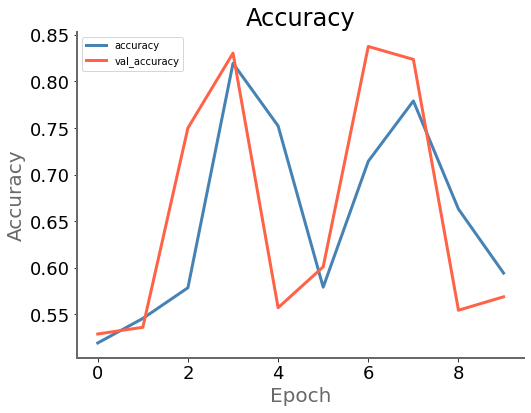

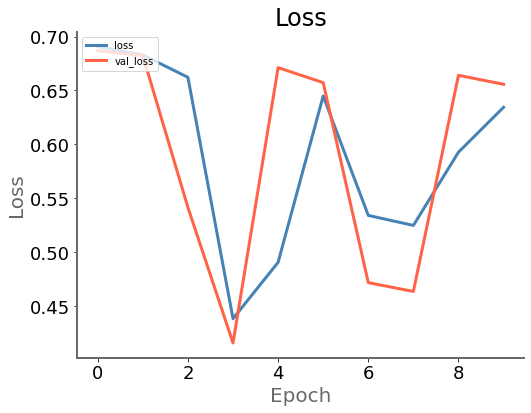

In [13]:
pwk.plot_history(history, save_as='02-history')

### 6.2 - Reload and evaluate best model

x_test / loss      : 0.4160
x_test / accuracy  : 0.8304


#### Accuracy donut is :

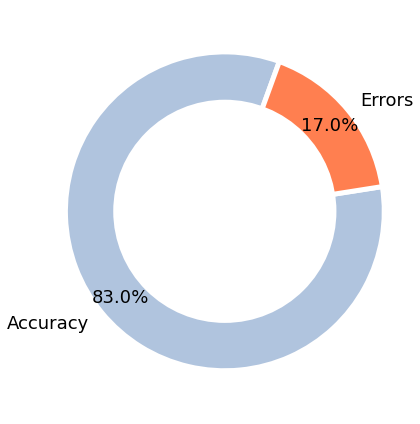

#### Confusion matrix is :

,0,1
0,0.76,0.24
1,0.10,0.90


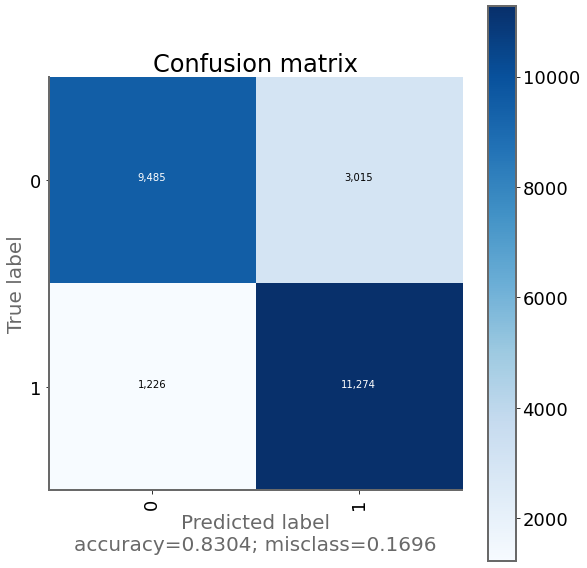

In [14]:
model = keras.models.load_model('./run/models/best_model.h5')

# ---- Evaluate
score  = model.evaluate(x_test, y_test, verbose=0)

print('x_test / loss      : {:5.4f}'.format(score[0]))
print('x_test / accuracy  : {:5.4f}'.format(score[1]))

values=[score[1], 1-score[1]]
pwk.plot_donut(values,["Accuracy","Errors"], title="#### Accuracy donut is :", save_as='03-donut')

# ---- Confusion matrix

y_sigmoid = model.predict(x_test)

y_pred = y_sigmoid.copy()
y_pred[ y_sigmoid< 0.5 ] = 0
y_pred[ y_sigmoid>=0.5 ] = 1    

pwk.display_confusion_matrix(y_test,y_pred,labels=range(2))
pwk.plot_confusion_matrix(y_test,y_pred,range(2), figsize=(8, 8),normalize=False, save_as='04-confusion-matrix')

In [15]:
pwk.end()

End time is : Wednesday 10 February 2021, 10:55:16
Duration is : 00:07:34 702ms
This notebook ends here


---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>